<a href="https://colab.research.google.com/github/LDankert/ANNs-Tensorflow/blob/verasBranch/IANNwTF_Homework_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time

## **1. Dataset**

In [161]:
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'} 
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key]) 
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8) 
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

In [162]:
train_dataset = tfds.load('genomics_ood', split='train[:10%]', shuffle_files=True, as_supervised=True)
test_dataset = tfds.load('genomics_ood', split='test[:1%]', shuffle_files=True, as_supervised=True)

In [ ]:
train_ds = train_dataset.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))
test_ds = test_dataset.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))

In [164]:
# Shuffle the training and test datasets.
train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)

# Choose a mini-batch size of data to be used per iteration. 
train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

# Prefetch the next batch of data.
train_ds = train_ds.prefetch(16)
test_ds = test_ds.prefetch(16)

In [165]:
class Model(tf.keras.Model):
  
  def __init__(self):
    super().__init__()
    self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                          activation=tf.keras.activations.sigmoid)
    self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                          activation=tf.keras.activations.sigmoid)
    self.output_layer = tf.keras.layers.Dense(units=10,
                                        activation=tf.keras.activations.softmax)
    
  def call(self, inputs):
    x = self.hidden_layer_1(inputs)
    x = self.hidden_layer_2(x)
    x = self.output_layer(x)
    return x

In [166]:
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    train_loss = loss_function(target, prediction)
    sample_training_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_training_accuracy = np.mean(sample_training_accuracy)
    gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return train_loss , sample_training_accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [167]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1

start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. 
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing once before we begin.
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin.
train_loss, train_accuracy = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # Training (and checking in with training).
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input, target in train_ds:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_accuracy)
    
    # Track training loss and accuracy.
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_acc_agg))

    # Testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

end = time.time()
execution_time = int((end - start)/60)

print(f'Execution time: {execution_time} minutes and {execution_time % 60} seconds.')

Epoch: 0 starting with accuracy 0.10125942887931035
Epoch: 1 starting with accuracy 0.3192349137931034
Epoch: 2 starting with accuracy 0.3174164870689655
Epoch: 3 starting with accuracy 0.3793103448275862
Epoch: 4 starting with accuracy 0.32553205818965514
Epoch: 5 starting with accuracy 0.3193696120689655
Epoch: 6 starting with accuracy 0.3462755926724138
Epoch: 7 starting with accuracy 0.36169854525862066
Epoch: 8 starting with accuracy 0.3339507004310345
Epoch: 9 starting with accuracy 0.3726427801724138
Execution time: 7 minutes and 7 seconds.


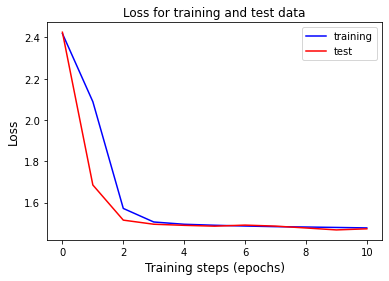

In [170]:
# Visualize loss training and test data. 
plt.figure()
line1, = plt.plot(train_losses, color = 'blue')
line2, = plt.plot(test_losses, color = 'red')
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend((line1, line2),("training", "test"))
plt.title('Loss for training and test data')
plt.show()

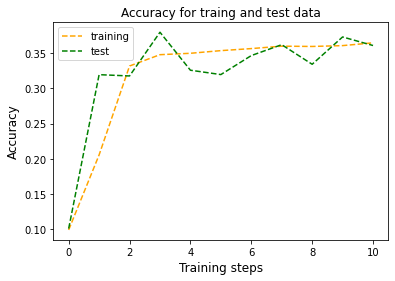

In [171]:
# Visualize accuracy for training and test data. 
plt.figure()
line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'orange')
line2, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'green')
plt.xlabel("Training steps", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.legend((line1, line2),("training", "test"))
plt.title('Accuracy for traing and test data')
plt.show()